## Coin Segmentation
using watershed and region props

**scikit-image**: segmentation and regionprops


In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage

skimage.__version__

'0.15.0'

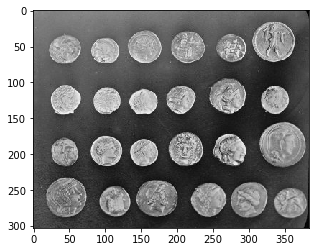

In [10]:
from skimage import data
coins = data.coins()
plt.imshow(coins, cmap='gray')

**Denoise image**

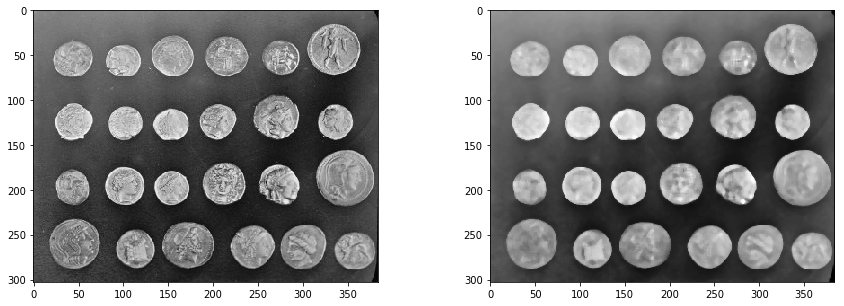

In [11]:
from skimage import filters

coins_denoised = filters.median(coins, selem=np.ones((5,5)))
f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(coins, cmap='gray')
ax1.imshow(coins_denoised, cmap='gray')

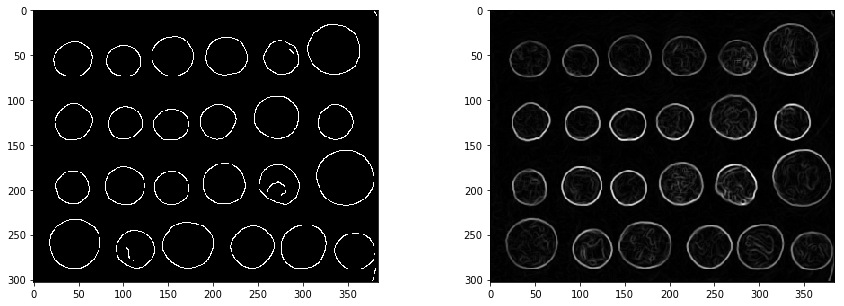

In [30]:
from skimage import feature, filters

edges = skimage.feature.canny(coins_denoised/255, sigma=3)
sobel_edges = skimage.filters.sobel(coins_denoised)

f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(edges, cmap='gray')
ax1.imshow(sobel_edges, cmap='gray')

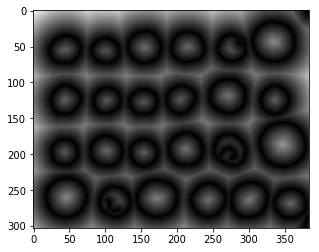

In [33]:
from scipy.ndimage import distance_transform_edt # euclidian distance - distance to closest background pixel 
dt = distance_transform_edt(~edges)              # call on negative of edges
plt.imshow(dt, cmap='gray')

**Watershed algorithm**

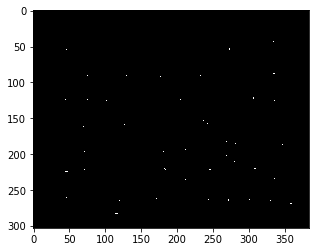

In [34]:
local_max = feature.peak_local_max(dt, indices=False, min_distance=5)
plt.imshow(local_max, cmap='gray')

In [0]:
peak_idx = 